In [1]:
!pip3 install -q numpy pandas matplotlib seaborn plotly tensorflow && clear

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,load_model

#Conv2D :Sees features in the image (like edges, curves, etc.)
#MaxPooling2D: Shrinks the image but keeps important parts (summarizes)
#BatchNormalization: Stabilizes learning by normalizing values in each layer
#Flatten: Prepares image data for decision-making by turning it into a 1D list
#Dense   : Makes the actual decision (fully connected layer)
#Dropout : Teaches the model to not rely too much on certain features (prevents overfitting)

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import cv2

In [3]:
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')




Mounted at /content/drive


In [4]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/arabicdataset.zip"
extract_path = "/content/drive/MyDrive/arabicdataset_extracted"

# Extract only if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed!")
else:
    print("Dataset already extracted.")


Dataset already extracted.


In [5]:
import pandas as pd

# Update paths based on extracted location
dataset_path = "/content/drive/MyDrive/arabicdataset_extracted"

Train_Images = pd.read_csv(f"{dataset_path}/csvTrainImages 13440x1024.csv")
Train_Labels = pd.read_csv(f"{dataset_path}/csvTrainLabel 13440x1.csv")
Test_Images = pd.read_csv(f"{dataset_path}/csvTestImages 3360x1024.csv")
Test_Labels = pd.read_csv(f"{dataset_path}/csvTestLabel 3360x1.csv")

print(f"Train Images : {Train_Images.shape}")
print(f"Test Images  : {Test_Images.shape}")


Train Images : (13439, 1024)
Test Images  : (3359, 1024)


In [6]:
print(f"Train Labels : {Train_Labels.shape}")
print(f"Test  Labels : {Test_Labels.shape}")

Train Labels : (13439, 1)
Test  Labels : (3359, 1)


In [7]:
Train_Images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13439 entries, 0 to 13438
Columns: 1024 entries, 0 to 0.905
dtypes: int64(1024)
memory usage: 105.0 MB


In [8]:
Train_Labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13439 entries, 0 to 13438
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       13439 non-null  int64
dtypes: int64(1)
memory usage: 105.1 KB


In [9]:
# Display the first 5 rows of the 'Train_Images' dataset,
# which contains pixel values of the training images (flattened to 1D arrays).Dense layer understand 1d layer can't understand rows n columns
# Each row represents a single image with 1024 pixel values.
Train_Images.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
Train_Images.isnull().sum() #checking null value(Nan)

,0
0,0
0.1,0
0.2,0
0.3,0
0.4,0
...,...
0.901,0
0.902,0
0.903,0
0.904,0


In [11]:
Test_Images.isnull().sum()

,0
0,0
0.1,0
0.2,0
0.3,0
0.4,0
...,...
0.924,0
0.925,0
0.926,0
0.927,0


In [12]:
Train_Labels.isnull().sum()

,0
1,0


In [13]:
Test_Labels.isnull().sum()

,0
1,0


In [14]:
import plotly.graph_objects as go

value_counts_data = Train_Labels.value_counts()

fig = go.Figure(data=[go.Pie(
    labels=value_counts_data.index,
    values=value_counts_data.values,
    textinfo='label+percent',
    insidetextorientation='radial',
    hole=0.6,
    marker=dict(
        colors=['#636EFB', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880'],
        line=dict(color='#ffffff', width=1)
    ),
)])

fig.update_layout(
    title='Train Labels Value Counts',
    font=dict(color='white'),
    paper_bgcolor='black',
    plot_bgcolor='black',
)

fig.show()


In [15]:
arabic_chars = ['alef','beh','teh','theh','jeem','hah','khah','dal','thal','reh','zain','seen','sheen','sad','dad','tah','zah','ain','ghain','feh','qaf','kaf','lam','meem','noon','heh','waw','yeh']
print(len(arabic_chars))

28


In [16]:
# converting Pandas DataFrames into NumPy arrays
x_train = Train_Images.to_numpy()
# Convert labels into NumPy arrays and subtract 1 from each label
# This shifts labels from starting at 1 to starting at 0, which is required for many ML models
y_train = Train_Labels.to_numpy()-1

# Repeat the same for the test data
x_test = Test_Images.to_numpy()
y_test = Test_Labels.to_numpy()-1

# Print the shape (dimensions) of the datasets to confirm the structure of the data
print(f"X_Train Shape : {x_train.shape}")
print(f"X_Test  Shape : {x_test.shape}")
print(f"Y_Train Shape : {y_train.shape}")
print(f"Y_Test  Shape : {y_test.shape}")

X_Train Shape : (13439, 1024)
X_Test  Shape : (3359, 1024)
Y_Train Shape : (13439, 1)
Y_Test  Shape : (3359, 1)


In [17]:
# Reshape the data to (number_of_images, 32, 32, 1) format for the model (32x32 grayscale images)
x_train = x_train.reshape(-1,32,32,1)# The '-1' means "let Python figure out how many images there are.
x_test  = x_test.reshape(-1,32,32,1)

# Normalize the pixel values to the range [0, 1] for better model performance
x_train = x_train / 255.0
x_test  = x_test / 255.0

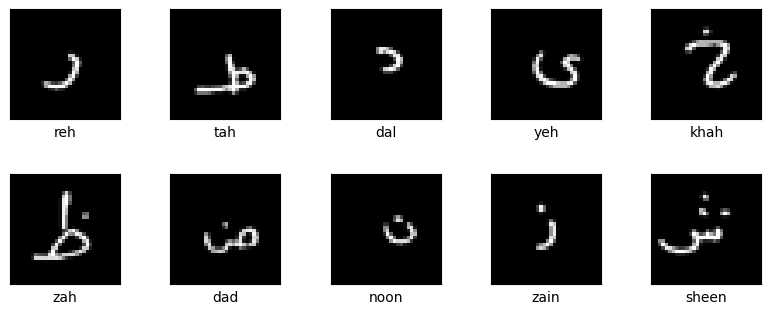

In [18]:
ra = np.random.randint(0, 13440, size=25)
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[ra[i]].reshape(32, 32).T, "gray")
    plt.xlabel(arabic_chars[int(y_train[ra[i]][0])], fontsize=10, color='black', ha='center')
    plt.subplots_adjust(hspace=0.5)
plt.show()

In [19]:
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
print(y_train.shape, y_test.shape)

(13439, 28) (3359, 28)


In [20]:
# Create a Sequential model, which is like stacking layers of a neural network on top of each other, one by one.

model = Sequential()

model.add(Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=(32, 32, 1)))
model.add(Conv2D(32, (5, 5), activation="relu"))
model.add(Conv2D(32, (5, 5), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (5, 5), padding="same", activation="relu"))
model.add(Conv2D(64, (5, 5), activation="relu"))
model.add(Conv2D(64, (5, 5), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))

# The final layer that makes the actual prediction.
# It has 28 neurons, each representing one possible class (for example, 28 different characters).
# Softmax function gives the probability of each class.

model.add(Dense(28, activation="softmax"))

# Compile the model: Set up the model to be ready for training.
# Use categorical cross-entropy as the loss function (for multi-class classification).
# Use the Adam optimizer to help the model learn.
# Track accuracy to see how well the model is performing during training
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,692 (1.38 MB)

 Trainable params: 361,500 (1.38 MB)

 Non-trainable params: 192 (768.00 B)

In [21]:
# Create image data generator to apply random zoom, shift, and rotation (data augmentation)
# Helps model generalize better and reduces overfitting
# - Rotate, zoom, and shift images slightly to simulate different handwriting styles
# - Helps the model generalize better
# - Normalization options are off since we already normalized by dividing by 255
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10, #Safe Range: 5 to 20
    zoom_range=0.1,# Safe Range: 0.1 to 0.3
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False, #For handwritten letters, flipping can change the meaning, so we keep it False.
    vertical_flip=False
)
train_gen = datagen.flow(x_train, y_train, batch_size=64)
test_gen  = datagen.flow(x_test , y_test , batch_size=64)

In [22]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="best.keras",  # Change extension from .hdf5 to .keras
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
history = model.fit(
    train_gen,
    epochs=50,
    verbose=1,
    steps_per_epoch=x_train.shape[0] // 64,
    validation_data=test_gen,
    validation_steps=x_test.shape[0] // 64,
    callbacks=[model_checkpoint_callback]
)
print("Train Successful !!")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2052 - loss: 2.6898
Epoch 1: val_accuracy improved from -inf to 0.03606, saving model to best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.2058 - loss: 2.6871 - val_accuracy: 0.0361 - val_loss: 7.5414
Epoch 2/50
  1/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5000 - loss: 1.6072

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.




Epoch 2: val_accuracy did not improve from 0.03606
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5000 - loss: 1.6072 - val_accuracy: 0.0358 - val_loss: 7.7896
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6158 - loss: 1.1276
Epoch 3: val_accuracy improved from 0.03606 to 0.34585, saving model to best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6161 - loss: 1.1268 - val_accuracy: 0.3459 - val_loss: 2.3978
Epoch 4/50
  1/209 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7969 - loss: 0.6842
Epoch 4: val_accuracy improved from 0.34585 to 0.35096, saving model to best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7969 - loss: 0.6842 - val_accuracy: 0.3510 - val_loss: 2.3340
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7819 - loss: 0.6515
Epoch 5: val_accuracy improved from 0.35096 to 0.78516, saving model to best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7820 - loss: 0.6513 - val_accu

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], name='Accuracy'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], name='Validation Accuracy'))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    legend=dict(x=0.7, y=0.9),
    width=800,
    height=600,
    plot_bgcolor='rgb(17,17,17)',
    paper_bgcolor='rgb(17,17,17)',
    font=dict(color='white')
)

fig.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


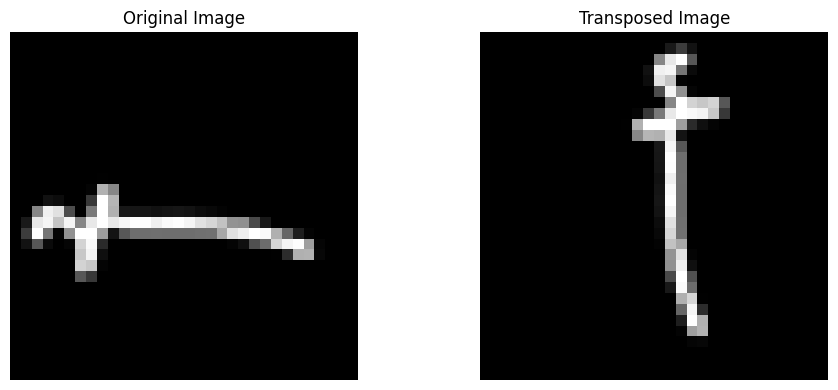

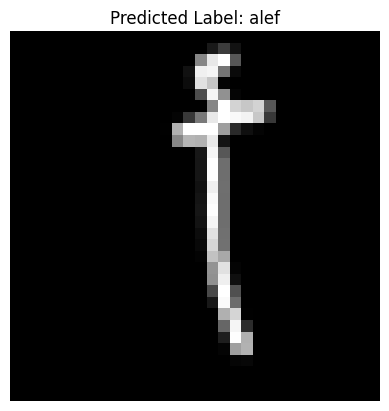

In [24]:
x_test_reshaped = x_test.reshape(-1, 32, 32, 1)

pred = model.predict(x_test_reshaped)

predicted_label = arabic_chars[np.argmax(pred[0])]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_test[0].reshape(32, 32), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(x_test[0].reshape(32, 32).T, cmap='gray')
plt.axis('off')
plt.title('Transposed Image')

plt.tight_layout()
plt.show()

plt.imshow(x_test[0].reshape(32, 32).T, cmap='gray')
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


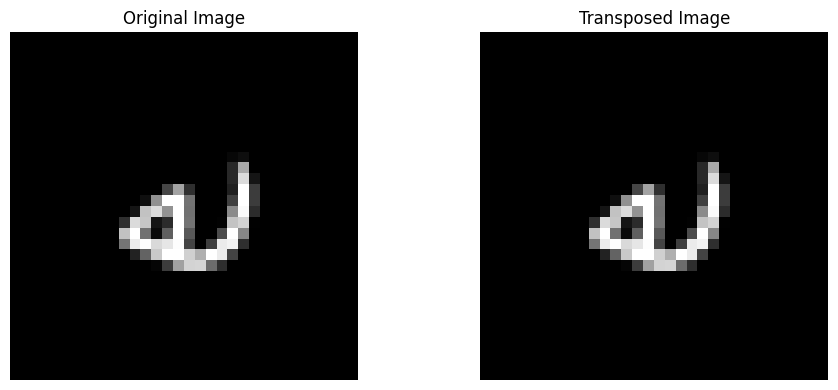

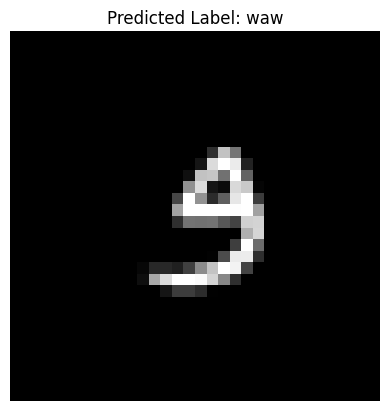

In [25]:
import matplotlib.pyplot as plt

# Select a different image from x_test (e.g., 5th image)
import random
image_index = random.randint(0, len(x_test) - 1)  # Random index in the range of x_test

#image_index = 4  # Change this to the index of the image you want to display
x_test_reshaped = x_test.reshape(-1, 32, 32, 1)

pred = model.predict(x_test_reshaped)

# Predict the label for the selected image
predicted_label = arabic_chars[np.argmax(pred[image_index])]

plt.figure(figsize=(10, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(x_test[image_index].reshape(32, 32), cmap='gray')
plt.axis('off')
plt.title('Original Image')

# Transposed Image
plt.subplot(1, 2, 2)
plt.imshow(x_test[image_index].reshape(32, 32), cmap='gray')
plt.axis('off')
plt.title('Transposed Image')

plt.tight_layout()
plt.show()

# Showing the predicted label with the transposed image
plt.imshow(x_test[image_index].reshape(32, 32).T, cmap='gray')
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()


In [26]:
y_preds = model.predict(x_test)
y_pred_classes = np.argmax(y_preds, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)


text = [[f"{cm[i, j]}<br>Correlation: {cm[i, j] / sum(cm[i, :]):.2f}" for j in range(len(cm[i]))] for i in range(len(cm))]

heatmap = go.Heatmap(
    z=cm,
    x=arabic_chars,
    y=arabic_chars,
    colorscale='Viridis',
    text=text,
    showscale=False,
    hoverongaps=False,
)

fig_cm = go.Figure(data=[heatmap])
fig_cm.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    width=800,
    height=600,
    template='plotly_dark',
    xaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='white'
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='white'
    )
)
fig_cm.update_traces(hovertemplate='%{text}<extra></extra>')
fig_cm.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [27]:
model.save("best_model.h5")


In [28]:
model.save("/content/drive/MyDrive/best_model.h5")


In [29]:
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")


Button(button_style='success', description='Upload and Predict', style=ButtonStyle())

Saving id_5_label_3.png to id_5_label_3.png
Uploaded File: id_5_label_3.png


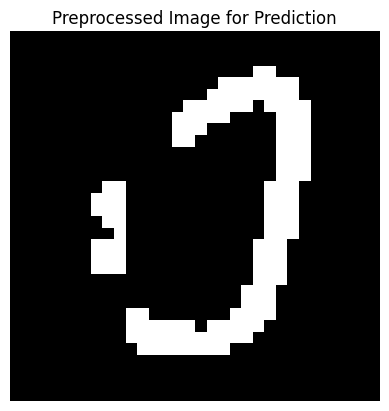

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Predicted Index: 2
Predicted label: teh


Saving id_10_label_5.png to id_10_label_5.png
Uploaded File: id_10_label_5.png


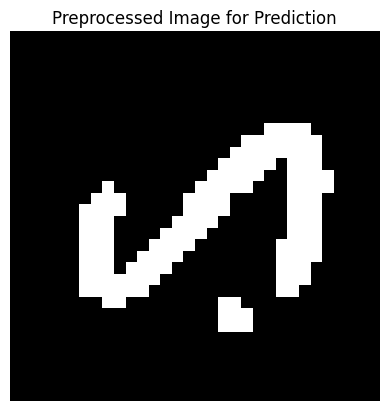

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Index: 4
Predicted label: jeem


Saving id_18_label_9.png to id_18_label_9.png
Uploaded File: id_18_label_9.png


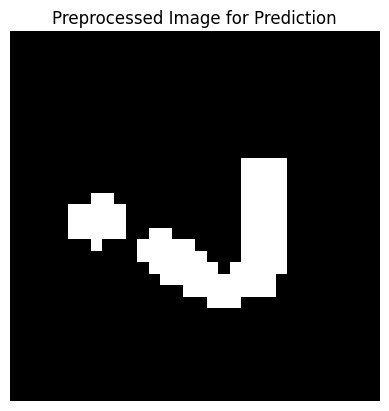

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Index: 8
Predicted label: thal


Saving id_11_label_6.png to id_11_label_6.png
Uploaded File: id_11_label_6.png


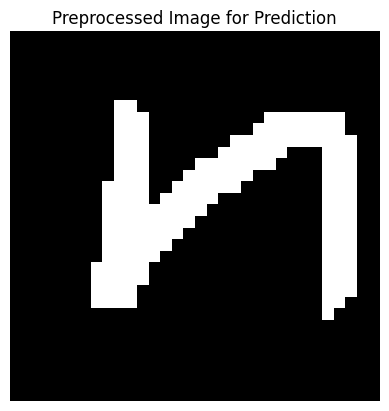

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Index: 6
Predicted label: khah


Saving id_26_label_13.png to id_26_label_13.png
Uploaded File: id_26_label_13.png


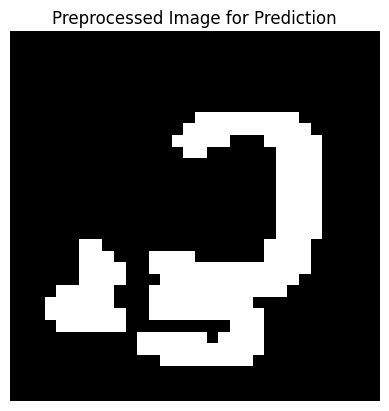

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Index: 12
Predicted label: sheen


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# Load the trained model
model_path = "/content/best_model.h5"
model = load_model(model_path)

# Arabic character labels
arabic_chars = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal', 'reh',
                'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 'ghain', 'feh',
                'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.resize(img, (32, 32))  # Resize to 32x32

    img = img.T  # Transpose the image (ensuring consistency)

    img = img.reshape(1, 32, 32, 1)  # Reshape for model input
    img = img.astype('float32') / 255.0  # Normalize

    plt.imshow(img.reshape(32, 32), cmap='gray')
    plt.title("Preprocessed Image for Prediction")
    plt.axis('off')
    plt.show()

    pred = model.predict(img)
    predicted_label = np.argmax(pred)  # Get the index of max probability

    print(f"Predicted Index: {predicted_label}")

    return arabic_chars[predicted_label]  # Map index to label

def upload_and_predict():
    uploaded = files.upload()  # Open file upload dialog
    for filename in uploaded.keys():
        print(f"Uploaded File: {filename}")
        prediction = predict_image(filename)
        print(f"Predicted label: {prediction}")

# Create an interactive button
button = widgets.Button(description="Upload and Predict", button_style='success')
button.on_click(lambda x: upload_and_predict())

# Display the button
display(button)



Upload an image for prediction:


Saving id_11_label_6.png to id_11_label_6.png
Uploaded File: id_11_label_6.png


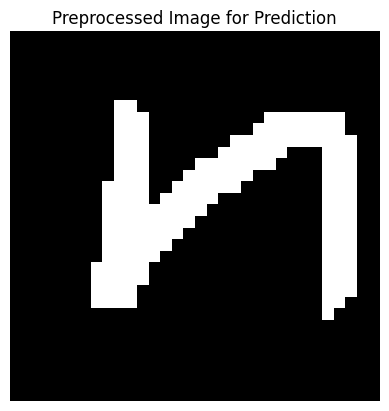

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted Index: 5
Predicted label: hah
Upload another image or stop execution if done.

Upload an image for prediction:


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files

# Load the trained model
model_path = "/content/drive/MyDrive/best_model.h5"
model = load_model(model_path)

# Arabic character labels
arabic_chars = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal', 'reh',
                'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 'ghain', 'feh',
                'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.resize(img, (32, 32))  # Resize to 32x32
    img = img.T  # Transpose the image (ensuring consistency)

    img = img.reshape(1, 32, 32, 1)  # Reshape for model input
    img = img.astype('float32') / 255.0  # Normalize

    plt.imshow(img.reshape(32, 32), cmap='gray')
    plt.title("Preprocessed Image for Prediction")
    plt.axis('off')
    plt.show()

    pred = model.predict(img)
    predicted_label = np.argmax(pred)  # Get the index of max probability

    print(f"Predicted Index: {predicted_label}")

    return arabic_chars[predicted_label]  # Map index to label

def upload_and_predict():
    while True:
        print("\nUpload an image for prediction:")
        uploaded = files.upload()  # Open file upload dialog

        for filename in uploaded.keys():
            print(f"Uploaded File: {filename}")
            prediction = predict_image(filename)
            print(f"Predicted label: {prediction}")

        # Ask if the user wants to continue
        print("Upload another image or stop execution if done.")

# Run the function to start continuous testing
upload_and_predict()

